In [50]:
import sys
sys.path.append("..")
from BacktestApp import BacktestApp
from utils import vwap, is_within_specific_minutes_of_close
from PositionManagerPlus import PositionManager

import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
import scipy.optimize as optimize
import matplotlib.pyplot as plt

def fit_piecewise_segments(df, x_col, y_col, count, plot=False, highlight=None):
    """
    使用分段拟合对数据进行 Piecewise Regression (支持时间作为 X 轴)

    参数:
    - df: pd.DataFrame, 需要包含 x_col 和 y_col 两列
    - x_col: str, 作为 X 轴的列名 (如果是时间列，会自动转换为数值)
    - y_col: str, 作为 Y 轴的列名
    - count: int, 需要分的段数

    返回:
    - px: np.ndarray, 分段的 x 轴坐标（原始时间格式）
    - py: np.ndarray, 分段的 y 轴坐标
    """
    # 转换时间列为数值（时间戳 -> 秒级浮点数）
    X = pd.to_datetime(df[x_col]).astype(np.int64) / 1e9  # 转换为秒
    Y = df[y_col].values

    xmin = X.min()
    xmax = X.max()

    # 计算初始分段点
    seg = np.full(count - 1, (xmax - xmin) / count)
    px_init = np.r_[np.r_[xmin, seg].cumsum(), xmax]
    py_init = np.array([Y[np.abs(X - x) < (xmax - xmin) * 0.01].mean() for x in px_init])

    def func(p):
        seg = p[:count - 1]
        py = p[count - 1:]
        px = np.r_[np.r_[xmin, seg].cumsum(), xmax]
        return px, py

    def err(p):
        px, py = func(p)
        Y2 = np.interp(X, px, py)
        return np.mean((Y - Y2) ** 2)

    r = optimize.minimize(err, x0=np.r_[seg, py_init], method='Nelder-Mead')

    # 将 px 转回时间格式
    px, py = func(r.x)
    px = pd.to_datetime(px * 1e9)  # 秒 -> 纳秒时间戳
    slope = (py[1] - py[0]) / py[0] / len(df) * 10000
    if plot:
        plt.plot(df[x_col], df[y_col], ".")
        plt.plot(px, py, "-or")
        if highlight:
            # 找到对应的 y 值
            highlight_y = df.loc[df[x_col] == highlight, y_col].values[0]  # 获取对应的 y 值
            # 标红该点
            plt.scatter(highlight, highlight_y, color='red', s=80, zorder=3)
    return slope

class Trend:
    def __init__(self, contract, pm:PositionManager):
        self.contract = contract
        self.pm = pm
        self.watch_id = None
        self.trend_df = None
        
    def calculate_open_amount(self, bars):
        if self.pm.net_liquidation is None or self.pm.available_funds is None:
            print("PositionManager.calculate_open_amount net_liquidation or available_funds is None")
            return 0
        
        target_market_value = self.pm.net_liquidation * 0.1
        if target_market_value > self.pm.available_funds: return 0
        
        open_amount = target_market_value / bars.iloc[-1]['close']
        open_amount = round(open_amount / 10) * 10  # 调整为 10 的倍数
        return int(open_amount)

    def find_position(self):
        is_match = lambda item: (
            item["contract"] == self.contract and
            item["strategy"] == "Trend"
        )
        return self.pm.find_position(is_match)
    
    def setParams(self, bars, period=5, amp=0.01, slope=1):
        bars['ema_10'] = bars['close'].ewm(span=10, adjust=False).mean()
        # 1. 根据 close 与 ema_10 的关系标记方向
        bars['direction'] = np.where(bars['close'] > bars['ema_10'], 'above', 'below')
        # 2. 利用相邻变化生成组号
        bars['group_id'] = (bars['direction'] != bars['direction'].shift()).cumsum()
        # 3. 对每个组统计最小值、最大值和计数
        group_stats = bars.groupby('group_id')['close'].agg(['min', 'max', 'count']).rename(columns={'count': 'n'})
        # 4. 计算波动幅度（百分比），注意防止除零问题
        group_stats['amp'] = group_stats.apply(lambda row: (row['max'] - row['min']) / row['min'] if row['min'] > 0 else 0, axis=1)
        # 5. 筛选出满足连续至少5分钟且波动大于0.5%的组
        valid_groups = group_stats[(group_stats['n'] >= period) & (group_stats['amp'] > amp)].index
        # 6. 初始化 slope 列
        group_stats['slope'] = np.nan

        # 7. 计算每个 valid_group 的 slope
        for group_id in valid_groups:
            group_df = bars[bars['group_id'] == group_id]
            _slope = fit_piecewise_segments(group_df, 'date', 'ema_10', count=1)
            group_stats.at[group_id, 'slope'] = _slope

        # 8. 根据 slope 进一步筛选 valid_groups（例如 slope > 0.01）
        final_groups = group_stats[(group_stats['slope'].notna()) & (group_stats['slope'].abs() > slope)].index
        # print(group_stats[(group_stats['slope'].notna()) & (group_stats['slope'].abs() > slope)])
        # 9. 标记符合最终条件的 group
        bars['rapid_stretch'] = bars['group_id'].isin(final_groups)

        bars['signal'] = pd.Series(np.nan, dtype='object')  # 确保数据类型为字符串兼容
        for group_id in final_groups:
            group_df = bars[bars['group_id'] == group_id]
            last_idx = group_df.index[-1]

            # 根据 slope 标记 BUY 或 SELL
            bars.at[last_idx, 'signal'] = 'SELL' if group_stats.at[group_id, 'slope'] > 0 else 'BUY'
        return bars
    
    def get_open_signal(self, bars, period=5, amp=0.01, slope=1):
        max_group_id = bars['group_id'].max()
        df = bars[bars['group_id'] == max_group_id]
        if len(df) < 2: return
        amptitude = ((df['close'].max() - df['close'].min()) / df['close'].min()) if df['close'].min() > 0 else 0
        if self.watch_id is not None and self.watch_id != max_group_id:
            watch_df = bars[bars['group_id'] == self.watch_id]
            if len(watch_df) < 3: print(watch_df)
            _slope = fit_piecewise_segments(watch_df, "date", "ema_10", count=1)
            if abs(_slope) > slope:
                self.watch_id = None
                self.trend_df = watch_df
                return "做多" if _slope > 0 else "做空"
        if len(df) > period and amptitude > amp:
            self.watch_id = max_group_id

    def get_close_signal(self, position, bars):
        """
        返回格式 减仓比例, 减仓原因
        减仓条件：
        1. 开仓后价格直接回到成交时的区间中轨，平仓（强制）
        2. 从最高点回落一半,平半仓（假突破）,回落到开仓价位以下时，再平半仓
        3. 如果走出单边走势,破ema10, 区间长度需要超过10分钟(止盈)
        """
        amount = position["amount"]
        direction = 1 if amount > 0 else -1
        pirce = bars.iloc[-1]['close']
        pnl_pct = (pirce - position["price"]) / position["price"] * direction
        # if pnl_pct > 0.015:
        #     return "止盈"
        # if pnl_pct < -0.01:
        #     return "止损"
        if bars.iloc[-1]["date"] == position["date"]: return
        if (amount > 0 and bars.iloc[-1]["close"] > self.trend_df["close"].max() * 1.008) or (amount < 0 and bars.iloc[-1]["close"] < self.trend_df["close"].min() * 0.992):
            return "止盈"
        if amount > 0:
            if bars.iloc[-1]["close"] < (0.2 * self.trend_df.iloc[0]["close"] + 0.8 * self.trend_df.iloc[-1]["close"]):
                self.trend_df = None
                return "止损"
        if amount < 0:
            if bars.iloc[-1]["close"] > (0.2 * self.trend_df.iloc[0]["close"] + 0.8 * self.trend_df.iloc[-1]["close"]):
                self.trend_df = None
                return "止损"
        if bars.iloc[-1]["date"] - position["date"] >= pd.Timedelta(minutes=15):
            return "时间到达"
    
    def prepare(self, bars, period=15, amp=0.01, slope=5):
        bars['ema_10'] = bars['close'].ewm(span=10, adjust=False).mean()
        # 1. 根据 close 与 ema_10 的关系标记方向
        bars['direction'] = np.where(bars['close'] > bars['ema_10'], 'above', 'below')
        # 2. 利用相邻变化生成组号
        bars['group_id'] = (bars['direction'] != bars['direction'].shift()).cumsum()
        return bars
    
    def update(self, bars):
        if len(bars) < 15: return
        bars = self.prepare(bars, period=15, amp=0.01, slope=5)
        # 反手信号（平仓部分）
        position = self.find_position()
        open_single = self.get_open_signal(bars, period=15, amp=0.01, slope=5)
        if open_single:
            direction = 1 if open_single == "做多" else -1
            if position and direction * position["amount"] < 0:
                self.pm.close_position(position, bars)
        
        # 开仓信号
        position = self.find_position()
        if open_single and not position and not is_within_specific_minutes_of_close(bars, 30):
            direction = 1 if open_single == "做多" else -1
            amount = direction * self.calculate_open_amount(bars)
            self.pm.open_position(self.contract, "Trend", amount, bars)

        # 收盘前平仓
        position = self.find_position()
        if position and is_within_specific_minutes_of_close(bars, 1):
            self.pm.close_position(position, bars)
            
        # 常规止盈止损
        position = self.find_position()
        if position:
            close_signal = self.get_close_signal(position, bars)
            if close_signal:
                reason = close_signal
                self.pm.close_position(position, bars, reason=reason)
                    
class TrendBacktestApp(BacktestApp):
    def __init__(self, config_file="config.yml", **kwargs):
        super().__init__(config_file, **kwargs)
        self.trend = { contract.symbol: Trend(contract, self.pm) for contract in self.contracts }
        self.sideways_count = 0
        self.has_trade_count = 0
        self.afterMarketCloseEvent = self.afterMarketCloseEvent + [self.after_market_close]
        
    def on_bar_update(self, contract, bars, has_new_bar):
        bars = bars.copy()
        self.trend[contract.symbol].update(bars)
        
    def after_market_close(self, date):
        for trend in self.trend.values():
            trend.watch_id = None

try:
    ba = TrendBacktestApp(config_file="../config_backtest.yml", clientId=20, debug=True, autoConnect=False)
    end_date = "2025-03-25"
    duration_str = "200 D"
    ba.minutes_backtest(end_date, duration_str)
finally:
    if ba.ib:
        ba.ib.disconnect()

【2024-06-06 09:59:00-04:00】【Trend】开仓: TSLA, 价格: 173.75, 数量：-580，浮动盈亏：None, 原因：None
【2024-06-06 10:14:00-04:00】【Trend】平仓: TSLA, 价格: 173.01, 数量：580，浮动盈亏：429.2000000000053, 原因：时间到达
【2024-06-11 10:04:00-04:00】【Trend】开仓: TSLA, 价格: 168.85, 数量：-590，浮动盈亏：None, 原因：None
【2024-06-11 10:16:00-04:00】【Trend】平仓: TSLA, 价格: 169.49, 数量：590，浮动盈亏：-377.6000000000087, 原因：止损
【2024-06-12 10:40:00-04:00】【Trend】开仓: TSLA, 价格: 176.29, 数量：570，浮动盈亏：None, 原因：None
【2024-06-12 10:55:00-04:00】【Trend】平仓: TSLA, 价格: 176.22, 数量：-570，浮动盈亏：-39.89999999999611, 原因：时间到达
【2024-06-13 10:41:00-04:00】【Trend】开仓: TSLA, 价格: 183.03, 数量：-550，浮动盈亏：None, 原因：None
【2024-06-13 10:43:00-04:00】【Trend】平仓: TSLA, 价格: 181.99, 数量：550，浮动盈亏：571.9999999999957, 原因：止盈
【2024-06-14 09:49:00-04:00】【Trend】开仓: TSLA, 价格: 182.92, 数量：-550，浮动盈亏：None, 原因：None
【2024-06-14 09:50:00-04:00】【Trend】平仓: TSLA, 价格: 183.11, 数量：550，浮动盈亏：-104.50000000001438, 原因：止损
【2024-06-14 10:17:00-04:00】【Trend】开仓: TSLA, 价格: 179.39, 数量：-560，浮动盈亏：None, 原因：None
【2024-06-14 10:32:00-04:00】【T

In [78]:
from PlotPlus import PlotPlus
idx = 0
daily = ba.get_historical_data(ba.contracts[0], end_date, duration_str, '1 day')

38 2024-08-01


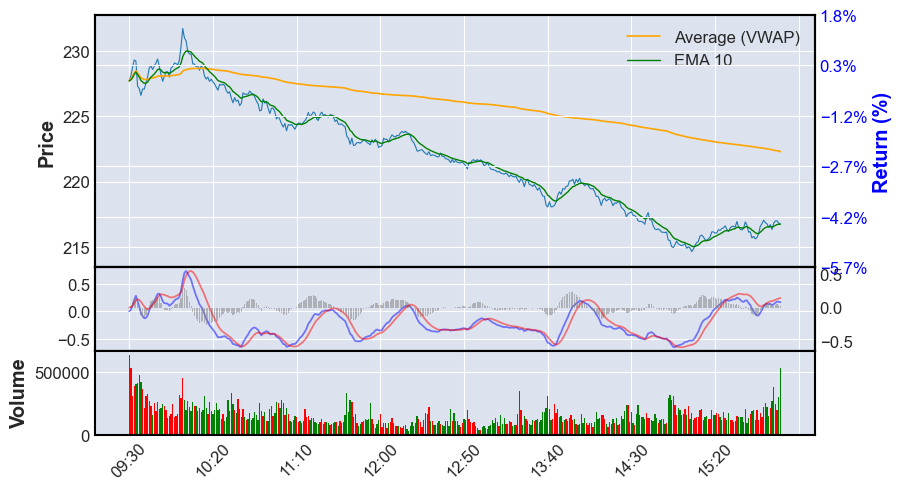

In [117]:
while True:
    date = daily.iloc[idx]['date']
    print(idx, date)
    idx += 1
    df = ba.get_historical_data(ba.contracts[0], date)
    st = Trend(ba.contracts[0], ba.pm)
    df = st.setParams(df, period=15, amp=0.01, slope=5)

    pp = PlotPlus(df)
    pp.plot_basic()
    pp.mark_segment("rapid_stretch")
    pp.mark_bs_point(ba.pm.trade_log)
    pp.mark_bs_point([])
    pp.show()
    break

In [62]:
ba.statistic()

{'cumulative_pnl': np.float64(2504.4056480005383),
 'max_drawdown': np.float64(0.006516640291937272),
 'sharpe_ratio': np.float64(-2.359706582382184),
 'volatility': np.float64(0.013218501346966258),
 'daily_return': np.float64(1.5111965723555376e-05),
 'commission': np.float64(4846.520736)}

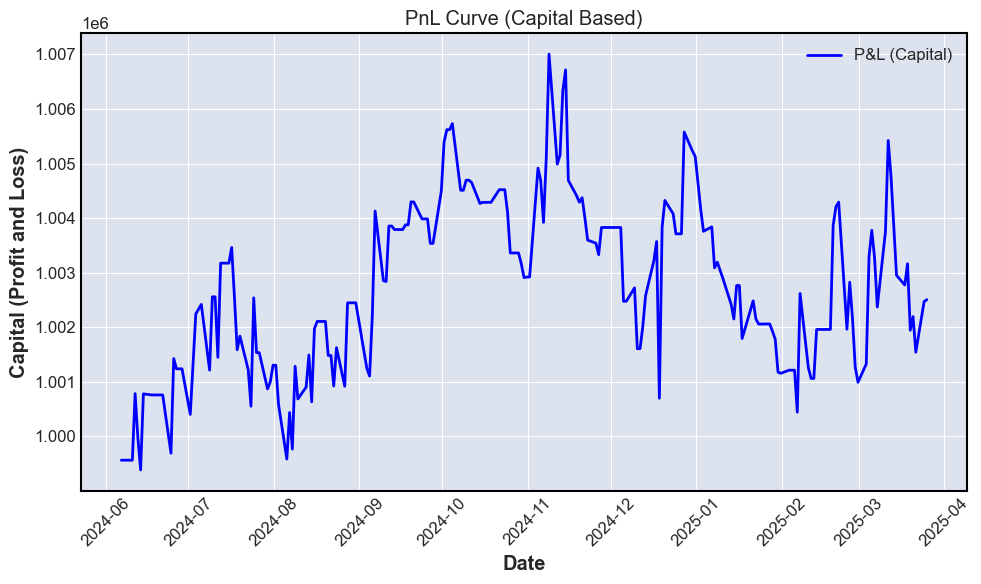

In [63]:
ba.plot_pnl()